## Motivation:

Retaining employee in an organization or keeping customers happy is a common use-case and valuable to know in an organization. The cost in rehiring or procuring customers vary from industry and organization. In both cases, the cheaper option is to offer incentives before employee or customer attrition.


## Scenario: Based on an Individual's Profile, Predict Customer Churn

Using [public data from Kaggle](https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers), predict customer churn or 'Exited' based on the Features provided.

Features: 

- RowNumber—corresponds to the record (row) number and has no effect on the output.
- CustomerId—contains random values and has no effect on customer leaving the bank.
- Surname—the surname of a customer has no impact on their decision to leave the bank.
- CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- Geography—a customer’s location can affect their decision to leave the bank.
- Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
- Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- NumOfProducts—refers to the number of products that a customer has purchased through the bank.
- HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- IsActiveMember—active customers are less likely to leave the bank.
- EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

Target: 
- Exited—whether or not the customer left the bank.



## Strategy

For this scenario, I will be using [XGBoost Algorithm](https://xgboost.readthedocs.io/en/stable/#).  It uses an ensemble of decision trees that essentially corrects itself with each iteration. By descending down on a gradient based on a learning rate, the goal of the algorithm is to minimize the error.  For intuition on the algorithm, I highly recommend checking this [video from StatQuest](https://www.youtube.com/watch?v=OtD8wVaFm6E). Hyperparameter tuning job will be inlisted.

In [177]:
!conda update scikit-learn --yes # Need to upgrade sklearn to allow SMOTE 

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done


In [178]:
!pip install seaborn --upgrade
!pip install altair
!pip install imblearn

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [179]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/bank-churn"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
import altair as alt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [181]:
start_time = time.time()

In [182]:
# Load Data

data = pd.read_csv('churn.csv')

In [183]:
# 10000 bank customers
data.shape

(10000, 14)

In [184]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploratory Data Analysis

Customers were pooled from three countries. 

In [185]:
data.groupby('Geography')['CustomerId'].count()

Geography
France     5014
Germany    2509
Spain      2477
Name: CustomerId, dtype: int64

Observing counts, we noticed that the ratio between staying as a customer and leaving is 4:1.  Meaning, most customers stay with the bank. That's good! However, this is an imbalance in our data and our model may not be able to pick up the patterns and feature to predict a customer leaving a bank. To address the issue, I will use SMOTE. 

In [186]:
data.groupby('Exited')['CustomerId'].count()

Exited
0    7963
1    2037
Name: CustomerId, dtype: int64

From the plots, they are mostly gaussian distribution. That's good, so we don't need to do some transformations.

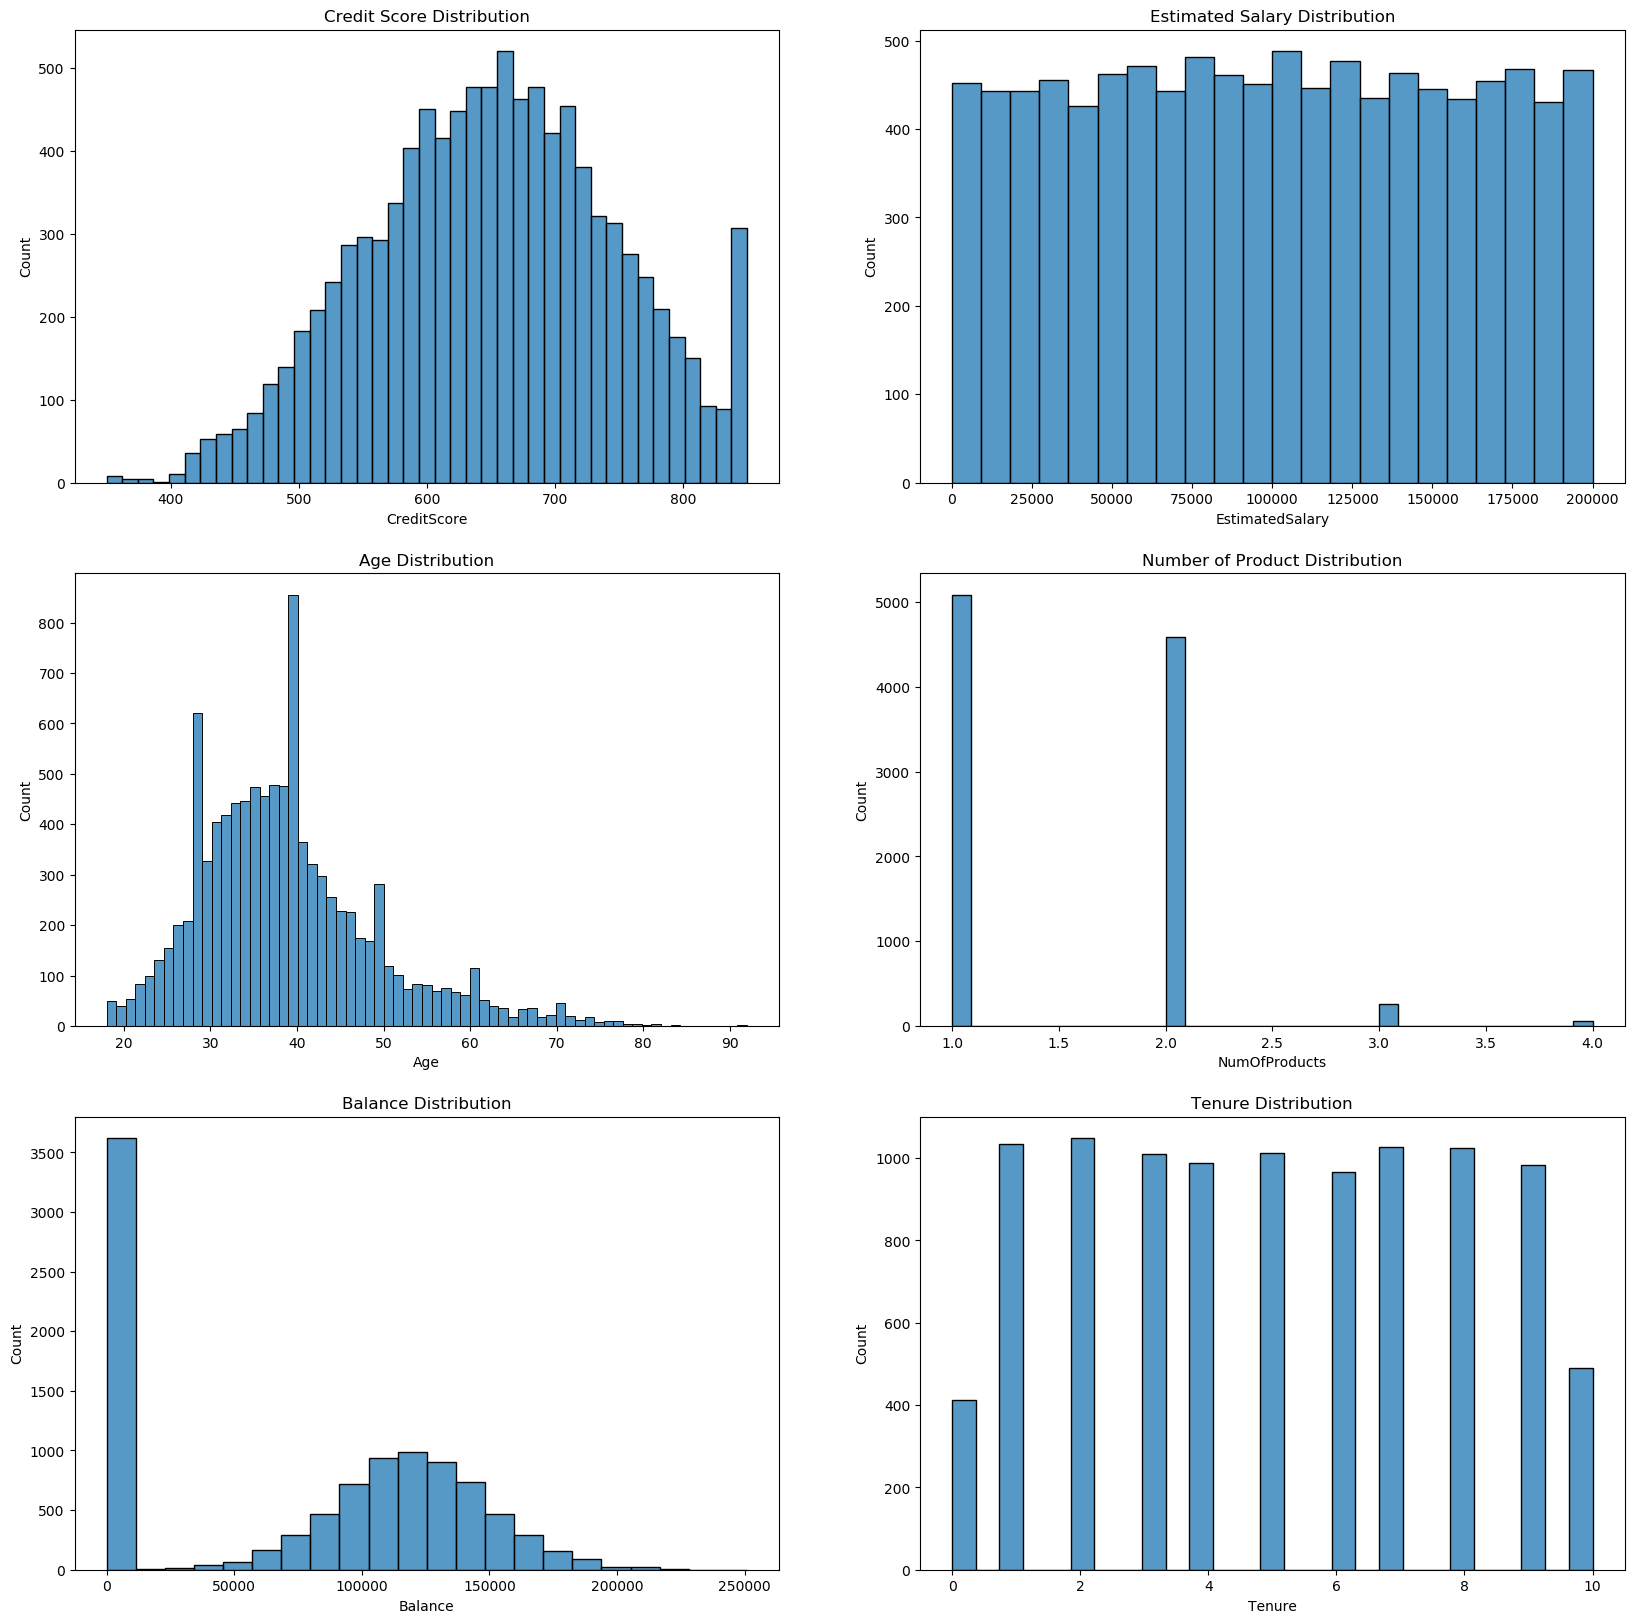

In [187]:
fig, axes = plt.subplots(3,2, figsize=(20,20)) 
sns.histplot(ax = axes[0][0], x=data.CreditScore).set(title = 'Credit Score Distribution')
sns.histplot(ax = axes[1][0], x=data.Age).set(title = 'Age Distribution')
sns.histplot(ax = axes[2][0], x=data.Balance).set(title = 'Balance Distribution')
sns.histplot(ax = axes[0][1], x=data.EstimatedSalary).set(title = 'Estimated Salary Distribution')
sns.histplot(ax = axes[1][1], x=data.NumOfProducts).set(title = 'Number of Product Distribution')
sns.histplot(ax = axes[2][1], x=data.Tenure).set(title = 'Tenure Distribution')
plt.show()

## Feature Engineering

It is not sufficient to convert categorical labels to numerical on a single column. For example, if we convert Geography from France, Germany, and Spain to 0,1,2, it implies there is ordering which introduce bias in the model. Therefore, need to utilize onehot encoding transformation to Country and also, Gender.

In [188]:
## Perform One Hot Encoding for Geography and Gender

data = pd.concat([data,pd.get_dummies(data.Geography, prefix='Country')], axis = 1)
data.drop(['Geography'], axis = 1, inplace = True)

data = pd.concat([data,pd.get_dummies(data.Gender, prefix='Gender')], axis = 1)
data.drop(['Gender'], axis = 1, inplace = True)


In [189]:
# Remove RowNumber, CustomerId, and Surname based on knowledge/domain experience.
data.drop(['RowNumber','CustomerId','Surname'], axis = 1, inplace = True)

In [190]:
# Reformatting so it can be accepted in xgboost.
#Note: For CSV training, the algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.
# See: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

features = ['CreditScore',	'Age',	'Tenure',	'Balance',	'NumOfProducts',	'HasCrCard',	'IsActiveMember',	'EstimatedSalary',		'Country_France',	'Country_Germany',	'Country_Spain',	'Country_France',	'Country_Germany',	'Country_Spain',	'Gender_Female',	'Gender_Male']

data = pd.concat((data['Exited'], data[features]), axis = 1)

In [191]:
data.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Country_France,Country_Germany,Country_Spain,Country_France,Country_Germany,Country_Spain,Gender_Female,Gender_Male
0,1,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0,0,1,0
1,0,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,0,1,1,0
2,1,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0,0,1,0
3,0,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0,0,1,0
4,0,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,0,1,1,0


In [192]:
data.shape

(10000, 17)

In [193]:
"""
## WIP: Resampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(np.array(data[features]), np.array(data['Exited']))
data_resampled = np.concatenate((y_res.reshape(-1,1), X_res), axis = 1)
data_resampled.shape


# Use this block for the resampled dataset
train_data, validation_data, test_data = np.split(
    data_resampled,
    [int(0.7 * len(data_resampled)), int(0.9 * len(data_resampled))],
)

train_data, validation_data, test_data = pd.DataFrame(train_data), pd.DataFrame(validation_data), pd.DataFrame(test_data)


"""

"\n## WIP: Resampling\nsm = SMOTE(random_state=42)\nX_res, y_res = sm.fit_resample(np.array(data[features]), np.array(data['Exited']))\ndata_resampled = np.concatenate((y_res.reshape(-1,1), X_res), axis = 1)\ndata_resampled.shape\n\n\n# Use this block for the resampled dataset\ntrain_data, validation_data, test_data = np.split(\n    data_resampled,\n    [int(0.7 * len(data_resampled)), int(0.9 * len(data_resampled))],\n)\n\ntrain_data, validation_data, test_data = pd.DataFrame(train_data), pd.DataFrame(validation_data), pd.DataFrame(test_data)\n\n\n"

## Split to Train, Validation, and Test Set

In [194]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(11148, 23)
(3185, 23)
(1593, 23)


In [195]:
# code borrowed from sagemaker notebook: xgboost_customer_churn.ipynb

train_data, validation_data, test_data = np.split(
    data.sample(frac=1, random_state=42),
    [int(0.7 * len(data)), int(0.9 * len(data))],
)

print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)


(7000, 17)
(2000, 17)
(1000, 17)


In [196]:
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

In [197]:
# Upload data to our bucket.

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

Note: Typically, we would perform scaling after data is split. We don't want to leak out information to the test set when performing the scaling. It is supposed to be unseen data. Howerver, for Decision Tree and Ensemble Techniques like XGBoost this is not required.

See [article](https://medium.com/codex/feature-scaling-in-machine-learning-e86b360d1c31#:~:text=Important%20Points%20to%20Remember%3A,data%20into%20training%20and%20testing)

## Train the Model

In [198]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

In [199]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [200]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    eval_metric="auc",
    max_depth=5,
    objective="binary:logistic",
    num_round=10,
)



In [201]:
from sagemaker.tuner import (
    ContinuousParameter,
    HyperparameterTuner,
)

# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
# Setting up Hyperparamters and job

objective_metric_name = "validation:auc"


hyperparameter_ranges = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "gamma": ContinuousParameter(0.01, 10, scaling_type="Logarithmic")
}


In [202]:
tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=5,
)

# Train the Model
tuner_log.fit({"train": s3_input_train, "validation": s3_input_validation})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................!


## Make the Endpoint

In [203]:

xgb_predictor = tuner_log.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)


2022-12-17 18:05:24 Starting - Preparing the instances for training
2022-12-17 18:05:24 Downloading - Downloading input data
2022-12-17 18:05:24 Training - Training image download completed. Training in progress.
2022-12-17 18:05:24 Uploading - Uploading generated training model
2022-12-17 18:05:24 Completed - Resource retained for reuse
--------!

## Make Inferences

For CSV inference, the algorithm assumes that CSV input does not have the label column.
See: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

In [204]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return predictions.split("\n")[:-1]


predictions = predict(test_data.to_numpy()[:, 1:])

In [205]:
predictions = np.array([float(num) for num in predictions])
#print(predictions)

## Evaluation



In context to this scenario, we want to balance between recall and precision. If we maximize recall and reduce churn, the number of incentives must be increased. However, precision will inevitably decrease because more false-positives will occur. Eventually, the cost of incentives will outweigh the churn prevented. In economics, the theory behind this is the law of diminishing return or what my co-worker says, "having too many chefs in the kitchen". 

Let's assume the cost of someone leaving is 100 dollars and the cost of incentives is 20 dollars. The cost function to minimize is:

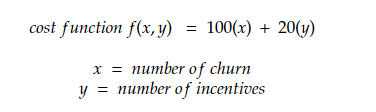



False Positive is when the customer is predicted to leave, but they ended up staying.
False Negative is when a customer is predicted to stay, but they ended up leaving.
True Positive is when the customer is predicted to leave, and they indeed left.
True Negative is when the customer is predicted to stay, and they indeed stay.

Precision is a measurement to test how well the model performs when predicting the signal, customer churn. 

See [article](https://towardsdatascience.com/predicting-and-preventing-the-churn-of-high-value-customers-using-machine-learning-adbb4a61095d) and [article](https://www.vidora.com/ml-in-business/reducing-user-churn-with-machine-learning-precision-and-recall/)

In [206]:
# Confusion Matrix

pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)


predictions,0.0,1.0
actual,,
0,768,28
1,122,82


In [207]:
print(f"The Accuracy Score is: {accuracy_score(test_data.iloc[:, 0],np.round(predictions))}")
print(f"The Precision Score is: {precision_score(test_data.iloc[:, 0],np.round(predictions))}")
print(f"The Recall Score is: {recall_score(test_data.iloc[:, 0],np.round(predictions))}")
print(f"The ROC AUC Score is: {roc_auc_score(test_data.iloc[:, 0],np.round(predictions))}")


The Accuracy Score is: 0.85
The Precision Score is: 0.7454545454545455
The Recall Score is: 0.4019607843137255
The ROC AUC Score is: 0.6833924524583702


In [208]:
end_time = time.time()
print(f"({(end_time-start_time)/60}) minutes have elapsed.")

(9.58075954914093) minutes have elapsed.


## Delete the Endpoint
When we're done making inferences

In [209]:
sess.delete_endpoint(endpoint_name=xgb_predictor.endpoint_name)


# Looking Ahead

1. Train with protobuf format and compare time between csv format.
2. Add DescribeTrainingJob into the notebook
3. SMOTE Implementation

## Resources:

1. https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.html
2. https://github.com/Kaggle/kaggle-api
   - to download files from kaggle
3. https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
   - subplots for seaborn
4. https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
   - one-hot encoding implementation
5. https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html
   - SageMaker Documentation for XGBoost
6. https://medium.com/codex/feature-scaling-in-machine-learning-e86b360d1c31#:~:text=Important%20Points%20to%20Remember%3A,data%20into%20training%20and%20testing
   - why you don't to scale data for xgboost
7. https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/xgboost_random_log/hpo_xgboost_random_log.ipynb
   - Hyperparameter tuning
8. https://towardsdatascience.com/predict-customer-churn-with-precision-56932ae0e5e3
   - Reference and Inspiration